## Dividing into train and validation and trying basic clfs (LogReg, Dec tree, MLP, SVM) (excluding Diagnosis code from features) 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import datetime
import numpy as np
import seaborn as sns
import re
import json
import pandas as pd
import math
import ast
import os
from collections import defaultdict
import sys
sys.path.append('..')
from utilities import logger
from utilities import configuration
from utilities import health_data

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier


### Recovering `conf` file and `log`

In [2]:
config = configuration.get_config()
for key in config:
    print(f'{key:40} (type: {type(config[key])})')


logging = logger.init_logger(config['system_log'])
logging.debug('Logger has started ont notebook 09 Random sample of instances.ipynb ...')

system_log                               (type: <class 'str'>)
logreg_log                               (type: <class 'str'>)
lasso_log                                (type: <class 'str'>)
logreg_results                           (type: <class 'str'>)
json_file                                (type: <class 'str'>)
train_val_json                           (type: <class 'str'>)
heldout_json                             (type: <class 'str'>)
unused_after_heldout_json                (type: <class 'str'>)
unified_merged_file_cz                   (type: <class 'str'>)
unified_merged_file_noncz                (type: <class 'str'>)
unified_merged_file                      (type: <class 'str'>)
data_path                                (type: <class 'str'>)
cz_files                                 (type: <class 'list'>)
noncz_files                              (type: <class 'list'>)
2023-11-22 10:55:08,761 - root - DEBUG - Logger has started ont notebook 09 Random sample of instances.ipynb ...


### Recovering file with train and validation instances

In [8]:
f = open(config['train_val_json'])
train_val_data = json.load(f)
print(len(train_val_data))

all_admissions = []
for ix in train_val_data:
    all_admissions.append(
        health_data.Admission.from_dict_data(admit_id=int(ix), admission=train_val_data[ix])
        )
len(all_admissions)

# Dictionary organizing data by patient
patient2admissions = defaultdict(list)
for admission in all_admissions:
    code = admission.code
    patient2admissions[code].append(admission)

# Ordering patient list by discharge date (from back )
for patient_code in patient2admissions:
    admissions_list = patient2admissions[patient_code]
    admissions_list = sorted(admissions_list, key=lambda admission: admission.discharge_date, reverse=False)
    assert all([admissions_list[i].discharge_date <= admissions_list[i+1].discharge_date for i in range(len(admissions_list)-1)])
    patient2admissions[patient_code] = admissions_list

patient_count=0
valid_readmission_count=0
for patient_code in patient2admissions:
    patient_admissions = patient2admissions[patient_code]
    ix = 0 
    while ix < len(patient_admissions):
        readmission_code = patient_admissions[ix].readmission_code
        if health_data.ReadmissionCode.is_readmit(readmission_code):
            # Either is not the first admission (ix>0) or 
            # we don't have the patient previous admition (readmission close to begining of dataset) (admit-(2015-01-01))<28 days
            # assert ix>0 or (patient_admissions[ix].admit_date - datetime.datetime.fromisoformat('2015-01-01')).days<365
            if ix>0 and  patient_admissions[ix-1].is_valid_readmission(patient_admissions[ix]):
                patient_admissions[ix-1].add_readmission(patient_admissions[ix])
                valid_readmission_count+=1
        ix+=1
    patient_count+=1


print(f'Size of train_val data:   {len(all_admissions):,}')
print(f"Begining heldout:         {min([admission.discharge_date for admission in all_admissions])}")
print(f"End heldout:              {max([admission.discharge_date for admission in all_admissions])}")
print(f'Number of instances with readmissions: {valid_readmission_count} ({valid_readmission_count/len(all_admissions):.2%})')



524986
Size of train_val data:   524,986
Begining heldout:         2015-01-01 00:00:00
End heldout:              2021-10-01 00:00:00
Number of instances with readmissions: 50533 (9.63%)


In [5]:
data = train_val_data
missing_count = len([data[key]['CMG'] for key in data.keys() if data[key]['Case Weight'] is None or np.isnan(data[key]['Case Weight'])])
print(f'{missing_count/len(data):.4%}')
print(missing_count)

0.0200%
105


### Validating dates in heldout data (not used in this notebook)

In [21]:
f = open(config['heldout_json'])
heldout_data = json.load(f)
print(f'Size of held-out data:   {len(heldout_data):,}')
print(f"Begining heldout:        {min([heldout_data[ix]['Discharge Date'] for ix in heldout_data])}")
print(f"End heldout:             {max([heldout_data[ix]['Discharge Date'] for ix in heldout_data])}")
del(heldout_data)

Size of held-out data:   74,350
Begining heldout:        2021-10-02 00:00:00
End heldout:             2022-10-02 00:00:00


### Splitting whole set into two (train and validation)
First create a random seed, then we use that seed to create a random_generator (to allow reproducibility)

In [ ]:
# --------------------------
# !!!!! DO NOT RUN !!!!!!!!!
# --------------------------

# np.random.randint(2**63)
# output 5348363479653547918

5348363479653547918

In [4]:
rng = np.random.default_rng(seed=5348363479653547918)

train_indexes = rng.choice(range(len(all_admissions)),size=int(0.8*len(all_admissions)), replace=False)

# Checking that every time I am getting the same training instances ( and validation instances)
assert all(train_indexes[:3] ==np.array([478898, 46409, 322969]))
assert all(train_indexes[-3:] ==np.array([415014, 330673, 338415]))
assert hash(tuple(train_indexes))==2028319680436964623

train_indexes = set(train_indexes)

train = [admission for ix, admission in enumerate(all_admissions) if ix in train_indexes ]
validation = [admission for ix, admission in enumerate(all_admissions) if not ix in train_indexes ]

print(f'Size of training (before filter)=     {len(train):,}')
print(f'Size of validation (before filter)=   {len(validation):,}')

# Filtering missing values
train = list(filter(lambda admission: not admission.has_missing, train))
validation = list(filter(lambda admission: not admission.has_missing, validation))


# Filtering STILL_BORNS admissions
train = list(filter(lambda admission: admission.admit_category!=health_data.AdmitCategory.STILLBORN, train))
validation = list(filter(lambda admission: admission.admit_category!=health_data.AdmitCategory.STILLBORN, validation))

# Filtering CADAVER admissions
train = list(filter(lambda admission: admission.admit_category!=health_data.AdmitCategory.CADAVER, train))
validation = list(filter(lambda admission: admission.admit_category!=health_data.AdmitCategory.CADAVER, validation))


print(f'Size of training (after filter)=      {len(train):,}')
print(f'Size of validation (after filter)=    {len(validation):,}')

Size of training (before filter)=     419,988
Size of validation (before filter)=   104,998
Size of training (after filter)=      419,345
Size of validation (after filter)=    104,861


### Creating matrix (numeric matrix is normalized with StandarScaler)

In [54]:
scaler = StandardScaler()

numerical_matrix = health_data.Admission.continuos_matrix(train)
categorical_matrix = health_data.Admission.categorical_matrix(train)
stds = np.std(numerical_matrix,axis=0)
columns = health_data.Admission.continuos_columns()
for ix in range(numerical_matrix.shape[1]):
    mask = mask | np.array(numerical_matrix[:,ix] > stds[ix]*4)
    print(f'Removing {np.sum(numerical_matrix[:,ix] > stds[ix]*4):7,} from "{columns[ix]:15}" threshold: {stds[ix]*3:.4f}')
print(f'Total removed: {np.sum(mask)}')

numerical_matrix[0,:] = np.log10(numerical_matrix[0,:] + 1)
numerical_matrix[1,:] = np.log10(numerical_matrix[1,:] + 1)
numerical_matrix[4,:] = np.log10(numerical_matrix[4,:] + 1)

numerical_matrix = scaler.fit_transform(numerical_matrix[~mask,:])
categorical_matrix = categorical_matrix[~mask,:]
numerical_matrix.shape

Removing     986 from "Length of Stay " threshold: 160.4652
Removing   1,449 from "Case Weight    " threshold: 19.1449
Removing     143 from "CMG            " threshold: 736.4128
Removing   4,551 from "Age            " threshold: 70.6661
Removing   1,380 from "ALC Days       " threshold: 97.1513
Total removed: 6947


(412398, 5)

In [55]:
# numerical_matrix = health_data.Admission.continuos_matrix(train)
# categorical_matrix = health_data.Admission.categorical_matrix(train)
X_train = np.hstack([numerical_matrix,
                     categorical_matrix 
                     ])
y_train = health_data.Admission.get_y(train)
y_train = y_train[~mask]


numerical_matrix = health_data.Admission.continuos_matrix(validation)
numerical_matrix[:,0] = np.log10(numerical_matrix[:,0] + 1)
numerical_matrix[:,1] = np.log10(numerical_matrix[:,1] + 1)
numerical_matrix[:,4] = np.log10(numerical_matrix[:,4] + 1)

numerical_matrix = scaler.fit_transform(numerical_matrix)
categorical_matrix = health_data.Admission.categorical_matrix(validation)


# categorical_matrix = 
X_val = np.hstack([numerical_matrix, 
                   categorical_matrix])
y_val = health_data.Admission.get_y(validation)

print(f'X_train= {X_train.shape}')
print(f'y_train= {y_train.shape}')
print(f'X_val=   {X_val.shape}')
print(f'y_val=   {y_val.shape}')

X_train= (412398, 18)
y_train= (412398,)
X_val=   (104861, 18)
y_val=   (104861,)


(array([2.0150e+04, 3.7609e+04, 2.8659e+04, 1.2010e+04, 4.5080e+03,
        1.4770e+03, 4.0100e+02, 3.9000e+01, 7.0000e+00, 1.0000e+00]),
 array([-1.79090648, -0.90667907, -0.02245165,  0.86177576,  1.74600318,
         2.63023059,  3.514458  ,  4.39868542,  5.28291283,  6.16714025,
         7.05136766]),
 <BarContainer object of 10 artists>)

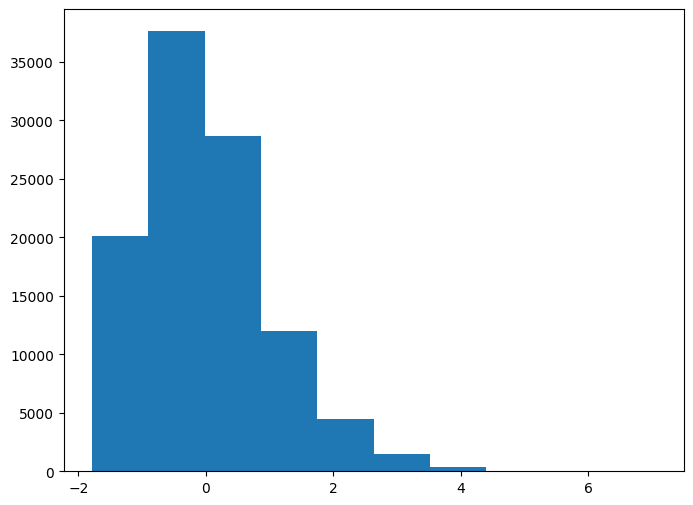

In [56]:
fig, ax = plt.subplots(1,figsize=(8,6))
ax.hist(numerical_matrix[:,0])

### Creating undersampled matrix (Under sampling majority class) (used for model who don't have the class_weight option)

In [10]:
number_of_positives_in_training = np.sum(y_train)
number_of_positives_in_training

positive_x = X_train[y_train==1,:]
negative_x = X_train[y_train==0,:]

print(positive_x.shape)
print(negative_x.shape)

under_sampling_ix = np.random.choice(range(negative_x.shape[0]), size=number_of_positives_in_training, replace=False)

under_sampled_negative_x = negative_x[under_sampling_ix,:]

print(positive_x.shape)
print(under_sampled_negative_x.shape)

undersampled_x = np.vstack([positive_x,under_sampled_negative_x])

print(undersampled_x.shape)

undersampled_y = np.array([1]*number_of_positives_in_training + [0]*number_of_positives_in_training)

print(undersampled_y.shape)
# X_train_under_sampled = X_train[under_sampling_ix,:]
# X_train_under_sampled.shape


(17412, 18)
(401933, 18)
(17412, 18)
(17412, 18)
(34824, 18)
(34824,)


In [57]:
print(' ** ** Logistic Regression (outliers removed and skew) ** **')
clf = LogisticRegression(random_state=0, max_iter=1000,class_weight='balanced').fit(X_train, y_train,)
y_true = y_train
y_pred = clf.predict(X_train)
print('** Results on Training **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')
print()


y_true = y_val
y_pred = clf.predict(X_val)
print('** Results on Training **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')
#  ** ** Logistic Regression (outliers removed) ** **
# ** Results on Training **
# Precision= 0.054
# Recall=    0.793
# F1-score=  0.101

# ** Results on Training **
# Precision= 0.056
# Recall=    0.792
# F1-score=  0.105

 ** ** Logistic Regression (outliers removed and skew) ** **
** Results on Training **
Precision= 0.054
Recall=    0.793
F1-score=  0.102

** Results on Training **
Precision= 0.056
Recall=    0.784
F1-score=  0.104


### Logistic Regression (balanced)

In [14]:
print(' ** ** Logistic Regression ** **')
clf = LogisticRegression(random_state=0, max_iter=1000,class_weight='balanced').fit(X_train, y_train,)
y_true = y_train
y_pred = clf.predict(X_train)
print('** Results on Training **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')
print()


y_true = y_val
y_pred = clf.predict(X_val)
print('** Results on Training **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')

 ** ** Logistic Regression ** **
** Results on Training **
Precision= 0.054
Recall=    0.802
F1-score=  0.101

** Results on Training **
Precision= 0.056
Recall=    0.807
F1-score=  0.104


#### Importance of different features in Logistic Regression

In [33]:
cols = health_data.Admission.continuos_columns() + health_data.Admission.categorical_columns()
for coef, col in sorted(zip(clf.coef_[0,:],cols),key=lambda value: np.abs(value[0]), reverse=True):
    print(f'{col:20}: {coef:7.3f}')

New Born Admission  :  -0.860
Level 1 Comorbidity :   0.789
Level 2 Comorbidity :   0.789
Level 3 Comorbidity :   0.737
Level 4 Comorbidity :   0.562
Urgent Admission    :   0.533
No Comorbidity      :   0.458
Is ALC              :  -0.455
Transfusion Given   :   0.414
Female              :  -0.356
Elective Admission  :  -0.313
Male                :  -0.253
Case Weight         :  -0.163
ALC Days            :  -0.160
Length of Stay      :   0.146
Is central Zone     :   0.048
CMG                 :  -0.048
Age                 :  -0.005


### SVM (Linear, balanced)

In [34]:
print(' ** **   SVM   (Linear) (outliers corrected) ** **')
clf = SVC(random_state=0, max_iter=10000, kernel='linear', class_weight='balanced').fit(X_train, y_train.ravel(),)
y_true = y_train
y_pred = clf.predict(X_train)
print('** Results on Training **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')
print()


y_true = y_val
y_pred = clf.predict(X_val)
print('** Results on Training **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')


 ** **   SVM   (Linear) (outliers corrected) ** **


/Users/marianomaisonnave/Environments/alc/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


** Results on Training **
Precision= 0.042
Recall=    0.984
F1-score=  0.081

** Results on Training **
Precision= 0.044
Recall=    0.991
F1-score=  0.084


In [16]:
print(' ** **   SVM   (Linear) ** **')
clf = SVC(random_state=0, max_iter=10000, kernel='linear', class_weight='balanced').fit(X_train, y_train.ravel(),)
y_true = y_train
y_pred = clf.predict(X_train)
print('** Results on Training **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')
print()


y_true = y_val
y_pred = clf.predict(X_val)
print('** Results on Training **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')


 ** **   SVM   (Linear) ** **


/Users/marianomaisonnave/Environments/alc/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


** Results on Training **
Precision= 0.042
Recall=    0.999
F1-score=  0.080

** Results on Training **
Precision= 0.043
Recall=    0.997
F1-score=  0.083


### SVM (RBF, balanced)

In [17]:
print(' ** **   SVM (RBF)   ** **')
clf = SVC(random_state=0, kernel='rbf', max_iter=10000,class_weight='balanced').fit(X_train, y_train.ravel(),)
y_true = y_train
y_pred = clf.predict(X_train)
print('** Results on Training **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')
print()


y_true = y_val
y_pred = clf.predict(X_val)
print('** Results on Training **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')


 ** **   SVM (RBF)   ** **


/Users/marianomaisonnave/Environments/alc/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


** Results on Training **
Precision= 0.051
Recall=    0.634
F1-score=  0.094

** Results on Training **
Precision= 0.053
Recall=    0.626
F1-score=  0.098


### Decision Tree (balanced with undersampling)

In [19]:
print(' ** **   Decision Tree   ** **')
clf = DecisionTreeClassifier(random_state=0).fit(undersampled_x, undersampled_y.ravel(),)
y_true = y_train
y_pred = clf.predict(X_train)
print('** Results on Training **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')
print()


y_true = y_val
y_pred = clf.predict(X_val)
print('** Results on Training **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')


 ** **   Decision Tree   ** **
** Results on Training **
Precision= 0.097
Recall=    0.986
F1-score=  0.177

** Results on Training **
Precision= 0.049
Recall=    0.575
F1-score=  0.090


### Decision Tree (not balanced)

In [22]:
print(' ** **   Decision Tree   ** **')
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.ravel(),)
y_true = y_train
y_pred = clf.predict(X_train)
print('** Results on Training **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')
print()


y_true = y_val
y_pred = clf.predict(X_val)
print('** Results on Training **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')


 ** **   Decision Tree   ** **
** Results on Training **
Precision= 0.998
Recall=    0.897
F1-score=  0.945

** Results on Training **
Precision= 0.059
Recall=    0.116
F1-score=  0.078


### MLP (balanced with undersampling, hidden_layer_sizes=`(300, 200, 100, 50, 20, 5, 4, 3, 2)`)

In [36]:
print(' ** **   MLP   ** **')
clf = MLPClassifier(random_state=0, 
                    # early_stopping=True, 
                    # n_iter_no_change=200,
                    # validation_fraction=0.2, 
                    max_iter=1000, 
                    hidden_layer_sizes=(300, 200, 100, 50, 20, 5, 4, 3, 2),
                    verbose=True)
clf.fit(undersampled_x, undersampled_y,)
y_true = y_train
y_pred = clf.predict(X_train)
print('** Results on Training **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')
print()


y_true = y_val
y_pred = clf.predict(X_val)
print('** Results on Validation **')
print(f'Precision= {precision_score(y_true, y_pred,):4.3f}')
print(f'Recall=    {recall_score(y_true, y_pred,):4.3f}')
print(f'F1-score=  {f1_score(y_true, y_pred,):4.3f}')


 ** **   MLP   ** **
Iteration 1, loss = 0.66665176
Iteration 2, loss = 0.65892955
Iteration 3, loss = 0.65631846
Iteration 4, loss = 0.65448327
Iteration 5, loss = 0.65293521
Iteration 6, loss = 0.65135114
Iteration 7, loss = 0.64913607
Iteration 8, loss = 0.64810033
Iteration 9, loss = 0.64718905
Iteration 10, loss = 0.64534718
Iteration 11, loss = 0.64443307
Iteration 12, loss = 0.64322995
Iteration 13, loss = 0.64176864
Iteration 14, loss = 0.64200421
Iteration 15, loss = 0.63983588
Iteration 16, loss = 0.63867002
Iteration 17, loss = 0.63696668
Iteration 18, loss = 0.63659016
Iteration 19, loss = 0.63584601
Iteration 20, loss = 0.63412637
Iteration 21, loss = 0.63256733
Iteration 22, loss = 0.63105161
Iteration 23, loss = 0.63013559
Iteration 24, loss = 0.62872462
Iteration 25, loss = 0.62696446
Iteration 26, loss = 0.62611542
Iteration 27, loss = 0.62501343
Iteration 28, loss = 0.62301208
Iteration 29, loss = 0.62147913
Iteration 30, loss = 0.61996888
Iteration 31, loss = 0.61874